In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

# 要下载的地址用一个字典存，
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"      # 如果该name不在DATA_HUB中则会报错
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)       # 创建文件夹，exist_ok=True在目标目录已存在的情况下不会触发FileExistsError异常
    fname = os.path.join(cache_dir, url.split('/')[-1])     # url.split('/')[-1]以/分割url放入数组去除倒数第一个
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)  # 读取最大行数为1048576
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
# 下载训练集和测试集的地址
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))  # 读取csv文件
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
'''输出文件的维数'''
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
# 输出前四个数据的前四维和倒三维
# iloc 即对数据进行位置索引，从而在数据表中提取出相应的数据
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [9]:
# pd.concat 数据合并
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [10]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
# numeric_features 表示单个数据的维度
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# print(numeric_features.shape)
# print(all_features.shape)

# 使用零均值规范化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 下面这种是最大最小规范化
# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: (x - min(x)) / (max(x) - min(x)))

# 归一化规范法
# all_features[numeric_features] = all_features[numeric_features].apply(
#     lambda x: x / sum(x))

# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [11]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# 为了防止某些情况下将数据以boolean流读入，使用dtype=int
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=float)

all_features.shape

(2919, 330)

In [12]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 用于训练的标签是 SalePrice， value是提取其值，reshape(-1,1) 在行上变化，也就是只有一行
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [13]:
# 创建一个均方误差损失函数对象
loss = nn.MSELoss()
# in_features 存储的是每个数据对象有多少个维度
in_features = train_features.shape[1]

def get_net():
    """
        nn.Sequential 是一个容器，存储的是神经网络中的层，每个层的输入要和前一个层的输出相匹配
        Linear 是线性回归适合运用于房价预测场景中
    """
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [14]:
"""
    求误差
        1. 先对预测值进行限幅
        2. 对预测值和标签取对数
        3. 两者进行平方后相减
        4. 开根号
"""
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    # torch.clamp 限幅函数, 将net(features) 限制在 1 到 float('inf')无穷大之间
    # net(features) 运行出来的就是预测值
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # torch.log 是以e为底取对数
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                            torch.log(labels)))
    # 直接return 每次迭代会导致空间占用增加，所以使用.item
    return rmse.item()

In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()   # 清除梯度
            l = loss(net(X), y)     # 计算损失
            l.backward()    # 计算梯度
            optimizer.step()    # step()方法来对所有的参数进行更新
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k     # 先做除法再做向下取整，每折的大小
    X_train, y_train = None, None   # 先至空
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)     # 要取出的数据分片
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part       # 验证折
        elif X_train is None:                       # 如果训练折为空
            X_train, y_train = X_part, y_part       # 训练折
        else:                                       # 如果训练折不为空
            # cat函数用于连接操作
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0     # 初始化训练误差和验证误差
    for i in range(k):      # k 折
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # 每次加上最新的一次迭代误差
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            # 绘制图形
            # 第一个参数作为横坐标范围，第二个参数作为纵坐标
            # xlabel：x轴的标签       ylabel：y轴的标签
            # legend：一个列表，包含图例标签的字符串。默认值为[]
            # xlim：一个元组，包含x轴范围的最小值和最大值。     ylim：一个元组，包含y轴范围的最小值和最大值。
            #  xscale：x轴的缩放类型。默认值为'linear'。     yscale：y轴的缩放类型。默认值为'linear'。
            # 参考https://blog.csdn.net/xuchaoxin1375/article/details/129754802
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170482, 验证log rmse0.156238
折2，训练log rmse0.162215, 验证log rmse0.191439
折3，训练log rmse0.163758, 验证log rmse0.168449
折4，训练log rmse0.168703, 验证log rmse0.155146
折5，训练log rmse0.163755, 验证log rmse0.182819
5-折验证: 平均训练log rmse: 0.165783, 平均验证log rmse: 0.170818


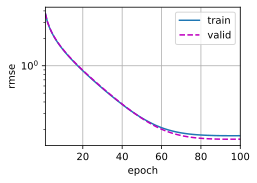

In [18]:
"""
    k 就是k折交叉验证
    num_epochs 模型训练迭代的总轮数
    lr 学习率或者说步长
    weight_decay 权重衰减
    batch_size 单次传递给程序训练的样本数
"""
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [35]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    # detach阻断反向传播，返回值仍为tensor  numpy()将tensor转换为numpy：
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    # print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])     # 利用上下两行代码， 本行相当于对预测值覆盖到实际值，而后形成csv模型提交
    # print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162489
     Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  \
0  1461          20       RH         80.0       WD        Normal   
1  1462          20       RL         81.0       WD        Normal   
2  1463          60       RL         74.0       WD        Normal   
3  1464          60       RL         78.0       WD        Normal   

       SalePrice  
0  119646.593750  
1  154889.718750  
2  198760.328125  
3  217516.437500  
     Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  \
0  1461          20       RH         80.0       WD        Normal   
1  1462          20       RL         81.0       WD        Normal   
2  1463          60       RL         74.0       WD        Normal   
3  1464          60       RL         78.0       WD        Normal   

       SalePrice  
0  119451.445312  
1  154115.703125  
2  198525.281250  
3  217137.359375  


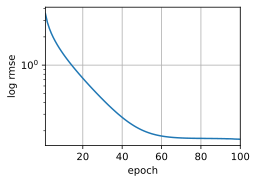

In [36]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)